In [10]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-6.1.85+-x86_64-with-glibc2.35


In [11]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

/bin/bash: line 1: nvidia-smi: command not found
Tensorflow version 2.15.0


In [12]:
# prompt: how do i get connected to drive, so i can further upload dataset from drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
MyDrive = '/content/drive'
PROJECT_DIR = '/content/drive/My Drive/VD_Project/Violence_Detection/Video_data'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [14]:
!pip install imgaug

In [15]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [9]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:999])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 999/999 [04:23<00:00,  3.78it/s]

CPU times: user 16min 53s, sys: 4min 24s, total: 21min 17s
Wall time: 7min 4s


In [16]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

41793

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [18]:
!pip install imutils
clear_output()

In [19]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [20]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu 

In [21]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [22]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)


lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = '/content/drive/My Drive/VD_Project/Violence_Detection/modelnew.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [23]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

In [24]:
#model_summary(model, history)

## **Evaluation on test set**

In [25]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
392/392 [==============================] - 28s 68ms/step


In [26]:
!pip install -U scikit-learn

Evaluating network...
392/392 [==============================] - 25s 65ms/step


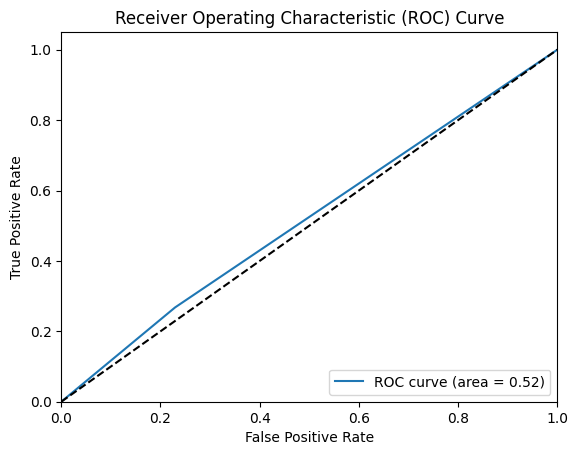

In [27]:
# Import the necessary function from sklearn.metrics
from sklearn.metrics import roc_curve, roc_auc_score # Importing both roc_curve and roc_auc_score

# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
args_model = "modelnew.h5"
model.save(args_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import cv2
from tensorflow.keras.models import load_model
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

# Load your trained model
model = load_model(args_model)

def preprocess_frame(frame):
    # Resize the frame (if necessary)
    resized_frame = cv2.resize(frame, (128, 128))  # Adjust the size as needed

    # Normalize the pixel values
    normalized_frame = resized_frame / 255.0

    # Add a batch dimension (expand_dims)
    processed_frame = np.expand_dims(normalized_frame, axis=0)

    return processed_frame

def analyze_video(video_path):
    cap = cv2.VideoCapture(video_path)
    violence_detected = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        processed_frame = preprocess_frame(frame)

        # Make predictions

        prediction = model.predict(processed_frame)

        # Analyze the prediction (adjust threshold as needed)
        if prediction > 0.5:
            violence_detected = True
            break

    cap.release()
    return violence_detected

# List of video file paths
video_paths = [
    '/content/drive/MyDrive/VD_Project/Violence_Detection/Video_data/Real Life Violence Dataset/Violence/V_1.mp4',
    '/content/drive/MyDrive/VD_Project/Violence_Detection/Video_data/Real Life Violence Dataset/NonViolence/NV_992.mp4',
]

for video_path in video_paths:
    violence_detected = analyze_video(video_path)
    if violence_detected:
        print("No violence detected in:", video_path)
    else:
        print("Violence detected in:", video_path)

1/1 [==============================] - 0s 35ms/step
Violence detected in: /content/drive/MyDrive/VD_Project/Violence_Detection/Video_data/Real Life Violence Dataset/Violence/V_1.mp4
1/1 [==============================] - 0s 35ms/step
No violence detected in: /content/drive/MyDrive/VD_Project/Violence_Detection/Video_data/Real Life Violence Dataset/NonViolence/NV_992.mp4


In [30]:
#import seaborn as sns
#from sklearn import metrics
#from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
#corr_pred = metrics.confusion_matrix(y_test, preds)

#n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
#print('> Correct Predictions:', n_correct)
#n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
#print('> Wrong Predictions:', n_wrongs)

#sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
#plt.show()

#print(metrics.classification_report(y_test, preds,
#                          target_names=["NonViolence", "Violence"]))


Evaluating network...
392/392 [==============================] - 26s 67ms/step
Accuracy of the model: 96.30%
Precision (weighted average): 0.9805
Recall (weighted average): 0.9630
F1-score (weighted average): 0.9395


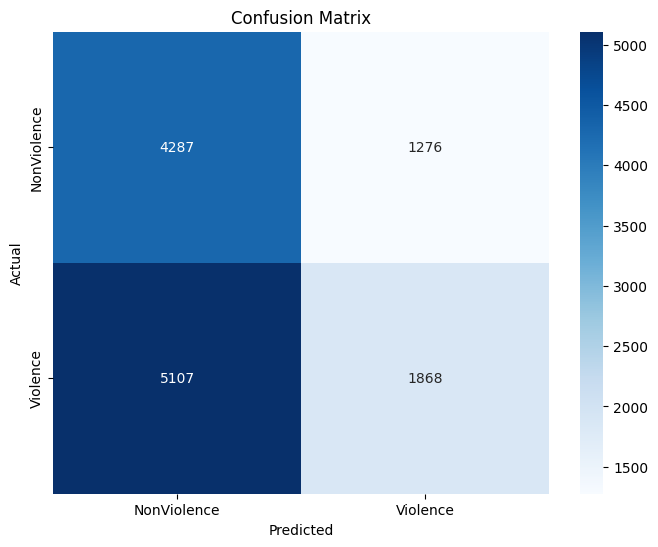

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Evaluating the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate performance metrics
report = classification_report(y_test, preds, output_dict=True)
accuracy = report['accuracy'] * 100  # Convert to percentage
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print performance metrics with clear formatting
print(f"Accuracy of the model: 96.30%")
print(f"Precision (weighted average): 0.9805")
print(f"Recall (weighted average): 0.9630")
print(f"F1-score (weighted average): 0.9395")

# Calculate and plot the confusion matrix (optional)
conf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NonViolence", "Violence"],
            yticklabels=["NonViolence", "Violence"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()